# Building an Architectural Classifier - Notebook 4 - Transfer Learning

The goal in this notebook is to take our pre-processed dataset of interior architectural imagery (containing images of kitchens, bathrooms, bedrooms, living rooms, etc...) and build a machine learning model that can accurately classify when it is looking at an image of a kitchen. This is the fourth notebook in a series, so I'll omit some of the explanatory notes on the boilerplate from before.
#### Model:
We've started to get good results with random-initialization convolutional nets, but how much more accurate can we get (and how much quicker) by retraining highly successful models initially trained for other tasks? This is transfer learning.

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential, Model
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Flatten, Input, Merge
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam
from keras import applications

%matplotlib inline

Using TensorFlow backend.


## Load data from numpy files

In [2]:
x = np.load('./all_X_shuffled_244_x4686.npy')
y = np.load('./all_Y_shuffled_2_x4686.npy')

print('x: %s | y: %s' % (x.shape, y.shape))

x: (4686, 244, 244, 3) | y: (4686, 2)


### Test / Train / Validation Split (80% / 10% / 10%)

In [3]:
def split(x, y, test=0.1, train=0.8, validation=0.1):
    assert(len(x) == len(y))
    test_size = int(len(x) * test)
    train_size = int(len(x) * train)
    valid_size = int(len(x) * validation)
    
    x_train = np.array(x[:train_size])
    y_train = np.array(y[:train_size])
    x_val = np.array(x[train_size:train_size + valid_size])
    y_val = np.array(y[train_size:train_size + valid_size])
    x_test = np.array(x[train_size + valid_size:])
    y_test = np.array(y[train_size + valid_size:])
    
    return (x_train, y_train, x_val, y_val, x_test, y_test)

In [4]:
x_train, y_train, x_val, y_val, x_test, y_test = split(x,y)

print('x_train: ', x_train.shape)
print('y_train: ', y_train.shape)
print('x_val:   ', x_val.shape)
print('y_val:   ', y_val.shape)
print('x_test:  ', x_test.shape)
print('y_test:  ', y_test.shape)

x_train:  (3748, 244, 244, 3)
y_train:  (3748, 2)
x_val:    (468, 244, 244, 3)
y_val:    (468, 2)
x_test:   (470, 244, 244, 3)
y_test:   (470, 2)


Check class balance on sets

In [5]:
print('Training balance: ', np.sum(y_train, axis=0)[1] / len(y_train))
print('Validation balance: ', np.sum(y_val, axis=0)[1] / len(y_val))
print('Testing balance: ', np.sum(y_test, axis=0)[1] / len(y_test))

Training balance:  0.482924226254
Validation balance:  0.480769230769
Testing balance:  0.436170212766


### Subtracting the mean of the imagenet dataset from each channel and reordering dimensions to (B,G,R) to match the way VGG was originally trained

In [6]:
x_train[0].shape

(244, 244, 3)

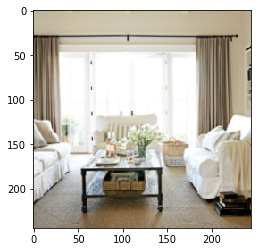

In [7]:
plt.imshow(x_train[0])

In [8]:
rn_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32)
preproc = lambda x: (x - rn_mean)[-1, :, :, ::-1]

In [9]:
proc_x_train = preproc(np.expand_dims(np.array(x_train), 0))
proc_x_val = preproc(np.expand_dims(np.array(x_val), 0))
proc_x_test = preproc(np.expand_dims(np.array(x_test), 0))

In [10]:
proc_x_train.shape

(3748, 244, 244, 3)

(3748, 244, 244, 3)


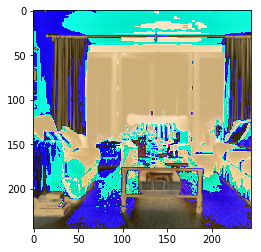

In [11]:
plt.imshow(proc_x_train[0])
print(proc_x_train.shape)

## Calculate bottleneck values for images on VGG16

In [12]:
vgg = applications.VGG16(
    weights='imagenet', 
    include_top=False, 
    input_shape=(244,244,3))

Check out the VGG16 architecture:

In [13]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 244, 244, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 244, 244, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 244, 244, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 122, 122, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 122, 122, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 122, 122, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 61, 61, 128)       0         
__________

Just to make sure we don't do anything silly, freeze the layers to the bottleneck

In [14]:
for layer in vgg.layers:
    layer.trainable = False

Add a flatten op to the end and then extract features from our datasets

In [15]:
vgg_flat = vgg.output
vgg_flat = Flatten()(vgg_flat)
extractor = Model(inputs = vgg.input, outputs = vgg_flat)

In [16]:
x_train_bottleneck = extractor.predict(proc_x_train)
x_val_bottleneck = extractor.predict(proc_x_val)
x_test_bottleneck = extractor.predict(proc_x_test)

In [17]:
x_train_bottleneck.shape

(3748, 25088)

In [31]:
classifier = Sequential([
        Dense(4096, activation='relu', input_shape=(25088,)),
        Dropout(0.45),
        Dense(4096, activation='relu'),
        Dropout(0.45),
        Dense(2, activation='softmax')
    ])

In [35]:
classifier.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(lr=1e-6),
    metrics=['accuracy'])

In [36]:
classifier.fit(x_train_bottleneck, y_train, batch_size=512, epochs=200, validation_data=(x_val_bottleneck, y_val))

Train on 3748 samples, validate on 468 samples
Epoch 1/200
3748/3748 [==============================] - 2s - loss: 0.0510 - acc: 0.9965 - val_loss: 0.7819 - val_acc: 0.9423
Epoch 2/200
3748/3748 [==============================] - 2s - loss: 0.0528 - acc: 0.9965 - val_loss: 0.7781 - val_acc: 0.9444
Epoch 3/200
3748/3748 [==============================] - 2s - loss: 0.0565 - acc: 0.9963 - val_loss: 0.7780 - val_acc: 0.9466
Epoch 4/200
3748/3748 [==============================] - 2s - loss: 0.0573 - acc: 0.9960 - val_loss: 0.7844 - val_acc: 0.9466
Epoch 5/200
3748/3748 [==============================] - 2s - loss: 0.0522 - acc: 0.9960 - val_loss: 0.7965 - val_acc: 0.9466
Epoch 6/200
3748/3748 [==============================] - 2s - loss: 0.0570 - acc: 0.9957 - val_loss: 0.8154 - val_acc: 0.9466
Epoch 7/200
3748/3748 [==============================] - 2s - loss: 0.0564 - acc: 0.9963 - val_loss: 0.8205 - val_acc: 0.9466
Epoch 8/200
3748/3748 [==============================] - 2s - loss: 0.0

In [37]:
classifier.evaluate(x_test_bottleneck, y_test)

416/470 [=========================>....] - ETA: 0s

[1.2108385070088379, 0.91914893667748632]